Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Setup plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

Configuration

In [2]:
PROCESSED_DIR = 'D:\skripsi_teknis\dataset\mitbih-afdb\processed'
PLOTS_DIR = 'D:\skripsi_teknis\\results\\analysis'

# Create directories if not exist
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Configuration:")
print(f"- Processed data: {PROCESSED_DIR}")
print(f"- Plots output: {PLOTS_DIR}")

Configuration:
- Processed data: D:\skripsi_teknis\dataset\mitbih-afdb\processed
- Plots output: D:\skripsi_teknis\results\analysis


Data Loading

In [3]:
def load_all_processed_data(processed_dir=PROCESSED_DIR):
    """Load semua preprocessed data"""
    
    print("🔄 Loading all preprocessed data...")
    
    # Find all processed files
    processed_files = glob.glob(os.path.join(processed_dir, 'record_*_processed.npz'))
    
    if not processed_files:
        print(f"❌ No processed files found in {processed_dir}")
        return None
    
    print(f"Found {len(processed_files)} processed files")
    
    all_windows = []
    all_labels = []
    record_info = []
    
    for i, file_path in enumerate(processed_files):
        try:
            data = np.load(file_path, allow_pickle=True)
            
            windows = data['windows']
            labels = data['labels']
            record_id = str(data['record_id'])
            
            all_windows.append(windows)
            all_labels.append(labels)
            
            af_count = int(np.sum(labels == 1))
            normal_count = int(np.sum(labels == 0))
            af_percentage = af_count / len(labels) * 100
            
            record_info.append({
                'record_id': record_id,
                'total_windows': len(labels),
                'af_windows': af_count,
                'normal_windows': normal_count,
                'af_percentage': af_percentage
            })
            
            print(f"✓ [{i+1:2d}] {record_id}: {len(labels):4d} windows ({af_percentage:5.1f}% AF)")
            
        except Exception as e:
            print(f"❌ Error loading {file_path}: {e}")
    
    if not all_windows:
        print("❌ No valid data loaded")
        return None
    
    # Combine all data
    print("\n🔄 Combining data...")
    X = np.vstack(all_windows)
    y = np.concatenate(all_labels)
    
    print(f"\n📊 Total data loaded:")
    print(f"- Records: {len(record_info)}")
    print(f"- Windows: {len(X):,}")
    print(f"- AF windows: {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.1f}%)")
    print(f"- Normal windows: {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.1f}%)")
    print(f"- Window length: {X.shape[1]} samples")
    
    return X, y, record_info

Data Quality Validation

In [4]:
def validate_data_quality(X, y):
    """Comprehensive data quality validation"""
    
    print("\n🔍 === Data Quality Validation ===")
    
    validation_results = {}
    
    # 1. Check for NaN/Inf values
    nan_count = np.sum(np.isnan(X))
    inf_count = np.sum(np.isinf(X))
    
    print(f"\n📋 Missing/Invalid Values:")
    print(f"- NaN values: {nan_count:,}")
    print(f"- Inf values: {inf_count:,}")
    
    validation_results['has_invalid'] = nan_count > 0 or inf_count > 0
    
    if validation_results['has_invalid']:
        print("⚠️  Warning: Data contains NaN or Inf values!")
    else:
        print("✅ No missing or invalid values found")
    
    # 2. Data statistics
    print(f"\n📊 Data Statistics:")
    print(f"- Shape: {X.shape}")
    print(f"- Min value: {np.min(X):.4f}")
    print(f"- Max value: {np.max(X):.4f}")
    print(f"- Mean: {np.mean(X):.4f}")
    print(f"- Std: {np.std(X):.4f}")
    print(f"- Data type: {X.dtype}")
    
    validation_results['stats'] = {
        'min': np.min(X),
        'max': np.max(X),
        'mean': np.mean(X),
        'std': np.std(X)
    }
    
    # 3. Label distribution
    label_counts = Counter(y)
    print(f"\n🏷️  Label Distribution:")
    for label, count in label_counts.items():
        label_name = "AF" if label == 1 else "Normal"
        percentage = count/len(y)*100
        print(f"- {label_name}: {count:,} ({percentage:.1f}%)")
    
    validation_results['label_distribution'] = label_counts
    
    # 4. Check for class imbalance
    imbalance_ratio = min(label_counts.values()) / max(label_counts.values())
    print(f"- Imbalance ratio: {imbalance_ratio:.3f}")
    
    if imbalance_ratio < 0.1:
        print("⚠️  Warning: Severe class imbalance detected!")
    elif imbalance_ratio < 0.3:
        print("⚠️  Warning: Moderate class imbalance detected")
    else:
        print("✅ Reasonable class balance")
    
    validation_results['imbalance_ratio'] = imbalance_ratio
    
    # 5. Window consistency
    unique_lengths = set(len(window) for window in X)
    print(f"\n📏 Window Consistency:")
    print(f"- Unique window lengths: {unique_lengths}")
    
    if len(unique_lengths) == 1:
        print("✅ All windows have consistent length")
    else:
        print("⚠️  Warning: Inconsistent window lengths!")
    
    validation_results['consistent_length'] = len(unique_lengths) == 1
    
    # Overall validation
    is_valid = (not validation_results['has_invalid'] and 
                validation_results['consistent_length'])
    
    print(f"\n🎯 Overall Validation: {'✅ PASSED' if is_valid else '❌ FAILED'}")
    
    return is_valid, validation_results

Data Visualization

In [5]:
def create_comprehensive_visualizations(X, y, record_info):
    """Create comprehensive data visualizations"""
    
    print("\n🎨 Creating visualizations...")
    
    # Setup
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Overall label distribution (Pie chart)
    ax1 = plt.subplot(3, 3, 1)
    labels = ['Normal', 'AF']
    counts = [np.sum(y == 0), np.sum(y == 1)]
    colors = ['lightblue', 'lightcoral']
    
    wedges, texts, autotexts = ax1.pie(counts, labels=labels, autopct='%1.1f%%', 
                                       startangle=90, colors=colors)
    ax1.set_title('Overall Label Distribution', fontsize=14, fontweight='bold')
    
    # 2. Sample ECG windows comparison
    ax2 = plt.subplot(3, 3, 2)
    af_indices = np.where(y == 1)[0]
    normal_indices = np.where(y == 0)[0]
    
    if len(af_indices) > 0 and len(normal_indices) > 0:
        # Plot multiple samples for better representation
        for i in range(min(3, len(normal_indices))):
            ax2.plot(X[normal_indices[i]], alpha=0.6, color='blue')
        for i in range(min(3, len(af_indices))):
            ax2.plot(X[af_indices[i]], alpha=0.6, color='red')
        
        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [Line2D([0], [0], color='blue', label='Normal'),
                          Line2D([0], [0], color='red', label='AF')]
        ax2.legend(handles=legend_elements)
    
    ax2.set_title('Sample ECG Windows', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Amplitude')
    ax2.grid(True, alpha=0.3)
    
    # 3. AF percentage per record
    ax3 = plt.subplot(3, 3, 3)
    df_records = pd.DataFrame(record_info)
    bars = ax3.bar(range(len(df_records)), df_records['af_percentage'], 
                   color='lightcoral', alpha=0.7)
    ax3.set_title('AF Percentage per Record', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Record Index')
    ax3.set_ylabel('AF Percentage (%)')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 4. Signal amplitude distribution
    ax4 = plt.subplot(3, 3, 4)
    sample_data = X[::100].flatten()  # Sample for efficiency
    ax4.hist(sample_data, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    ax4.set_title('Signal Amplitude Distribution', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Amplitude')
    ax4.set_ylabel('Frequency')
    ax4.grid(True, alpha=0.3)
    
    # 5. Windows count per record
    ax5 = plt.subplot(3, 3, 5)
    bars = ax5.bar(range(len(df_records)), df_records['total_windows'], 
                   color='lightblue', alpha=0.7)
    ax5.set_title('Total Windows per Record', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Record Index')
    ax5.set_ylabel('Number of Windows')
    ax5.grid(True, alpha=0.3)
    
    # 6. AF vs Normal comparison (box plot)
    ax6 = plt.subplot(3, 3, 6)
    af_means = [np.mean(X[i]) for i in af_indices[:1000]]  # Sample for performance
    normal_means = [np.mean(X[i]) for i in normal_indices[:1000]]
    
    box_data = [normal_means, af_means]
    box = ax6.boxplot(box_data, labels=['Normal', 'AF'], patch_artist=True)
    box['boxes'][0].set_facecolor('lightblue')
    box['boxes'][1].set_facecolor('lightcoral')
    
    ax6.set_title('Mean Amplitude Distribution', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Mean Amplitude')
    ax6.grid(True, alpha=0.3)
    
    # 7. Record summary table
    ax7 = plt.subplot(3, 3, 7)
    ax7.axis('tight')
    ax7.axis('off')
    
    summary_data = [
        ['Total Records', len(record_info)],
        ['Total Windows', f"{len(X):,}"],
        ['Window Length', f"{X.shape[1]} samples"],
        ['AF Windows', f"{np.sum(y == 1):,}"],
        ['Normal Windows', f"{np.sum(y == 0):,}"],
        ['AF Percentage', f"{np.sum(y == 1)/len(y)*100:.1f}%"]
    ]
    
    table = ax7.table(cellText=summary_data, 
                     colLabels=['Metric', 'Value'],
                     cellLoc='left',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax7.set_title('Dataset Summary', fontsize=14, fontweight='bold')
    
    # 8. Signal variance comparison
    ax8 = plt.subplot(3, 3, 8)
    af_vars = [np.var(X[i]) for i in af_indices[:1000]]
    normal_vars = [np.var(X[i]) for i in normal_indices[:1000]]
    
    ax8.hist(normal_vars, bins=30, alpha=0.6, label='Normal', color='blue')
    ax8.hist(af_vars, bins=30, alpha=0.6, label='AF', color='red')
    ax8.set_title('Signal Variance Distribution', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Variance')
    ax8.set_ylabel('Frequency')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # 9. Data quality indicators
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Quality checks
    nan_count = np.sum(np.isnan(X))
    inf_count = np.sum(np.isinf(X))
    unique_lengths = len(set(len(window) for window in X))
    
    quality_text = f"""
Data Quality Indicators:

✅ No NaN values: {nan_count == 0}
✅ No Inf values: {inf_count == 0}
✅ Consistent lengths: {unique_lengths == 1}

Signal Range: [{np.min(X):.3f}, {np.max(X):.3f}]
Signal Mean: {np.mean(X):.3f}
Signal Std: {np.std(X):.3f}
    """
    
    ax9.text(0.1, 0.9, quality_text, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
    ax9.set_title('Quality Indicators', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(PLOTS_DIR, 'data_analysis_comprehensive.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📁 Comprehensive plot saved: {plot_path}")
    
    plt.show()
    
    return df_records

Load and Analyze Data

🔄 Loading all preprocessed data...
Found 23 processed files
✓ [ 1] 04015: 1149 windows (  3.4% AF)
✓ [ 2] 04043: 6943 windows ( 21.1% AF)
✓ [ 3] 04048: 6128 windows (  1.0% AF)
✓ [ 4] 04126: 6630 windows (  4.0% AF)
✓ [ 5] 04746: 5984 windows ( 65.3% AF)
✓ [ 6] 04908: 7021 windows (  9.3% AF)
✓ [ 7] 04936: 6541 windows ( 79.9% AF)
✓ [ 8] 05091: 3466 windows (  0.3% AF)
✓ [ 9] 05121: 6284 windows ( 74.2% AF)
✓ [10] 05261: 5895 windows (  1.4% AF)
✓ [11] 06426: 4881 windows ( 94.6% AF)
✓ [12] 06453: 5969 windows (  1.1% AF)
✓ [13] 06995: 5008 windows ( 22.4% AF)
✓ [14] 07162: 7363 windows (100.0% AF)
✓ [15] 07859: 7363 windows (100.0% AF)
✓ [16] 07879: 5865 windows ( 75.7% AF)
✓ [17] 07910: 6582 windows (  7.5% AF)
✓ [18] 08215: 2570 windows ( 44.8% AF)
✓ [19] 08219: 4753 windows ( 32.2% AF)
✓ [20] 08378: 4742 windows ( 32.3% AF)
✓ [21] 08405: 2046 windows (  0.1% AF)
✓ [22] 08434: 2077 windows ( 13.5% AF)
✓ [23] 08455: 2275 windows (  0.4% AF)

🔄 Combining data...

📊 Total data loaded:


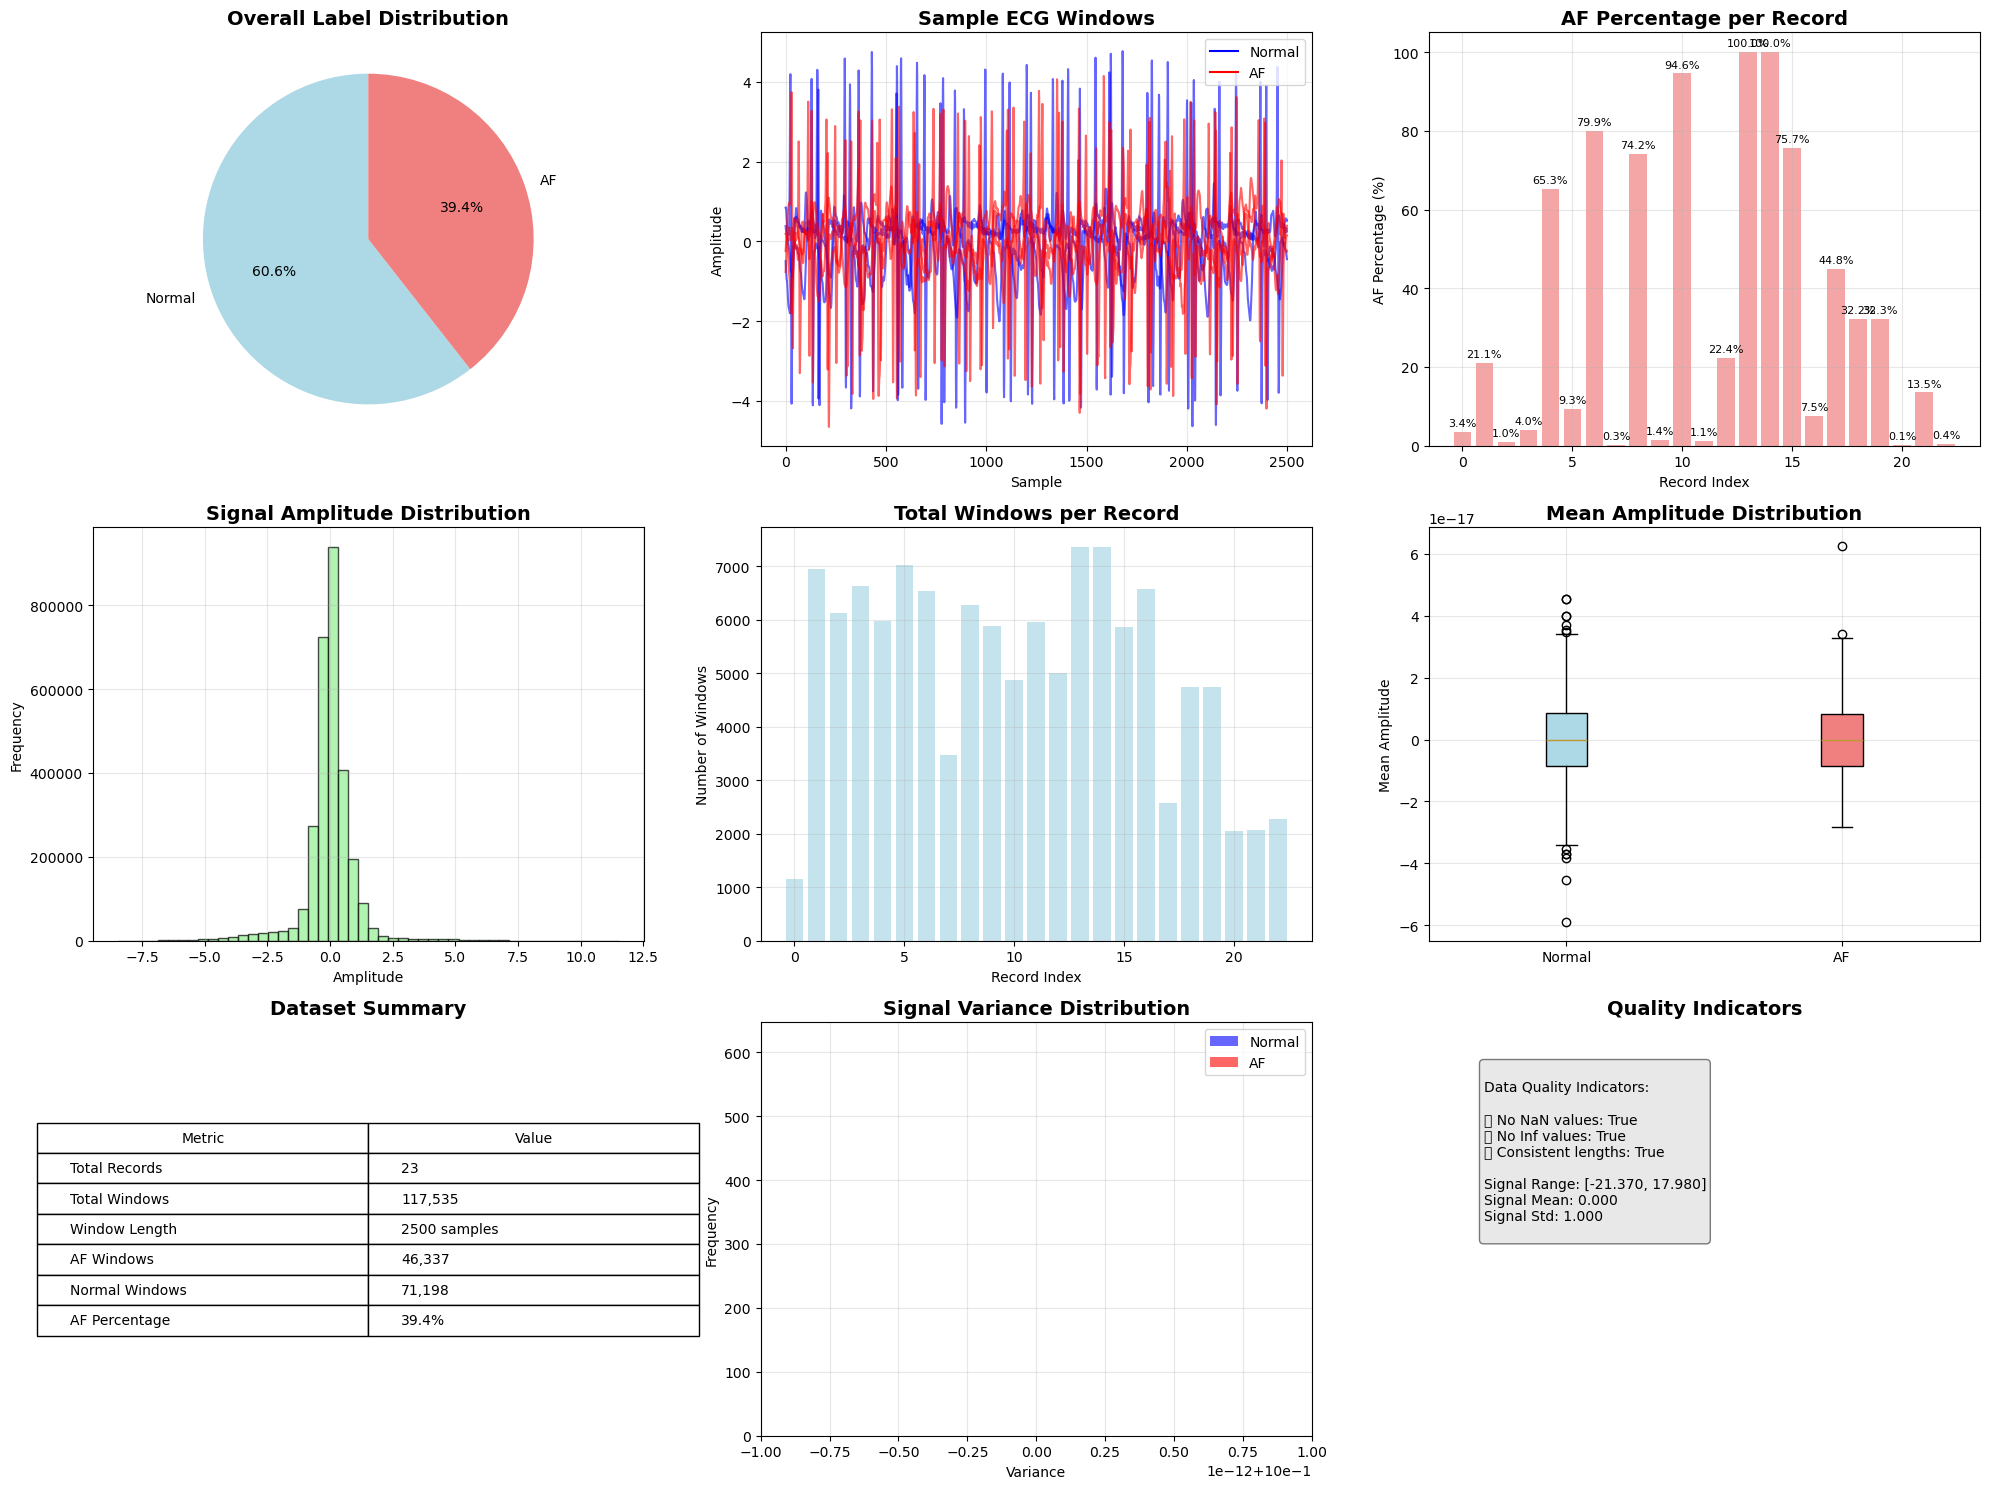


📋 Record Information:
record_id  total_windows  af_windows  normal_windows  af_percentage
    04015           1149          39            1110       3.394256
    04043           6943        1465            5478      21.100389
    04048           6128          62            6066       1.011749
    04126           6630         266            6364       4.012066
    04746           5984        3905            2079      65.257353
    04908           7021         656            6365       9.343398
    04936           6541        5224            1317      79.865464
    05091           3466           9            3457       0.259665
    05121           6284        4660            1624      74.156588
    05261           5895          82            5813       1.391009
    06426           4881        4615             266      94.550297
    06453           5969          66            5903       1.105713
    06995           5008        1122            3886      22.404153
    07162           7363 

In [6]:
# Load data
result = load_all_processed_data()

if result is None:
    print("❌ Failed to load data. Please check if preprocessing was completed.")
else:
    X, y, record_info = result
    print(f"\n✅ Data loaded successfully!")

# %%
# Validate data quality
if result is not None:
    is_valid, validation_results = validate_data_quality(X, y)
    
    if not is_valid:
        print("\n❌ Data validation failed! Please check the data quality issues above.")
    else:
        print("\n✅ Data validation passed! Proceeding with analysis...")

# %%
# Create visualizations
if result is not None and is_valid:
    df_records = create_comprehensive_visualizations(X, y, record_info)
    
    # Display record info table
    print("\n📋 Record Information:")
    print(df_records.to_string(index=False))

# %% [markdown]
## 🎯 Advanced Analysis

# %%
if result is not None and is_valid:
    print("\n🔬 === Advanced Analysis ===")
    
    # 1. Statistical analysis per class
    af_data = X[y == 1]
    normal_data = X[y == 0]
    
    print(f"\n📊 Class-wise Statistics:")
    print(f"Normal - Mean: {np.mean(normal_data):.4f}, Std: {np.std(normal_data):.4f}")
    print(f"AF     - Mean: {np.mean(af_data):.4f}, Std: {np.std(af_data):.4f}")
    
    # 2. Signal characteristics
    print(f"\n🔊 Signal Characteristics:")
    print(f"- Sampling frequency: 250 Hz (assumed)")
    print(f"- Window duration: {X.shape[1]/250:.1f} seconds")
    print(f"- Total duration: {len(X) * X.shape[1]/250/3600:.1f} hours")
    
    # 3. Memory usage
    memory_mb = X.nbytes / (1024**2)
    print(f"\n💾 Memory Usage:")
    print(f"- Data size: {memory_mb:.1f} MB")
    print(f"- Per window: {X.nbytes/len(X)/1024:.1f} KB")

# %% [markdown]
## 💾 Save Analysis Results

# %%
if result is not None and is_valid:
    # Save analysis summary
    analysis_summary = {
        'dataset_info': {
            'total_records': len(record_info),
            'total_windows': len(X),
            'window_length': X.shape[1],
            'af_windows': int(np.sum(y == 1)),
            'normal_windows': int(np.sum(y == 0)),
            'af_percentage': float(np.sum(y == 1)/len(y)*100)
        },
        'validation_results': validation_results,
        'record_details': record_info
    }
    
    # Save to file
    analysis_path = os.path.join(PLOTS_DIR, 'analysis_summary.npz')
    np.savez(analysis_path, **analysis_summary)
    print(f"\n💾 Analysis summary saved: {analysis_path}")
    
    print(f"\n✅ Data analysis complete!")
    print(f"📁 All plots saved in: {PLOTS_DIR}")